# Heterogeneous Agent Optimal Savings I
## Linear Interpolation
### By Alan Lujan

The Huggett, 1993 model is an ideal starting point for developing heterogeneous agent solution algorithms. This notebook presents standard solution algorithms with a few extensions. 

First, we import relevant python libraries that will be useful in our calculations. 
- `interpolation:` provides "jit" linear interpolation
- `matplotlib:` graph plotting library
- `numba`: provides just-in-time compilation for speedy calculation
- `numpy:` numerical library for working with arrays and vectorized functions
- `quantecon:` provides "jit" maximum search
- `scipy:` provides root finding algorithm
- `time:` enables time keeping 

In [1]:
from time import time  # time keeping

import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
from interpolation import interp  # linear interpolation
from numba import njit  # just-in-time compiling nopython
from numba import prange  # parallel range
from quantecon.optimize.scalar_maximization import (
    brent_max as argmax,
)  # finding maximum
from scipy.optimize import toms748 as root  # finding roots

%matplotlib inline

# Introduction

The most commonly used function for these models is the constant relative risk aversion (CRRA) specification, where the coefficient of risk aversion is $\sigma$. When $\sigma=1$, the limit of the function is $u(c)=\log(c)$, so in our definition we allow for different cases depending on the parameter. We use a function factory to create a jitted function for the model depending on the value of $\sigma$.

\begin{equation}
		\begin{gathered}
		\mathbb{E}_0 \left( \sum_{t=0}^{\infty} \beta^t u(c_t) \right) \quad \text{ where } \beta \in (0, 1), \text{ and}  \\
		u(c) = \lim_{\nu \to \sigma} \frac{c^{1-\nu}-1}{1-\nu} \quad \text{ where } \sigma \ge 1.
		\end{gathered}
\end{equation}

In [2]:
def utility(σ):
    @njit
    def log(c):
        return np.log(c)

    @njit
    def iso(c):
        return (c ** (1 - σ) - 1) / (1 - σ)

    return log if σ == 1.0 else iso

The environment is composed of ex-ante identical households with a labor income endowment $w_i$ and a net bond balance of $b$ (savings if positive, debt if negative). The household can then use their total period budget to choose consumption of a non-storable good and next period debt or savings in the form of discount bonds at the price of $q$. Thus the following recursive value function summarizes the household problem:

\begin{equation}
    \begin{gathered}
    V(w_i, b;q) = \underset{(c,b')\in \Gamma(w_i,b;q)}{\max} u(c) + \beta \sum_{i=1}^{Nz} \pi_{ij} V(w_j,b';q) \\
    \text{where} \\
    \Gamma(w_i,b;q) = \{(c,b'): c+qb' \le w_i + b; c \ge 0; b' \ge \underline{b} \}
    \end{gathered}
\end{equation}

The first step in solving the model is creating an object that contains the model parameters. I take advantage of python's object oriented programming to create a class of moodels named HAOS (heterogeneous agent optimal savings) that takes in the following parameters:

- $\sigma \ge 1$: CRRA parameter of relative risk aversion 
- $u$: jitted function to override the CRRA utility form, useful for different utility specifications
- $\beta$: household discount factor for future utility of consumption 
- $\omega$: the set of possible labor income endowments
- $\pi$: the transition probability matrix for the Markov chain process of labor income
- $\texttt{b\_bounds}$: the range of bonds over which we solve the value, policy, and distribution functions, where the lower bound serves as the credit limit
- $\texttt{Nb}$: number of grid points used to solve the value function
- $\texttt{N}\mu$: number of grid points used to solve the distribution function

In [3]:
# Heterogeneous agent optimal savings
class HAOS(object):
    def __init__(
        self,
        σ=1.5,  # CRRA parameter
        u=None,  # user defined utility override
        β=0.99322,  # discount factor
        ω=[0.1, 1.0],  # labor earnings endowment
        π=[[0.5, 0.5], [0.075, 0.925]],  # earnings transition matrix
        b_bounds=[-4.0, 4.0],  # credit limits
        Nb=100,  # number of value function grid points
        Nμ=1000,
    ):  # number of distribution grid points

        self.σ = σ if u is None else None
        self.u = utility(σ) if u is None else u
        self.β = β
        self.ω, self.π = np.array(ω), np.array(π)
        blow, bhigh = b_bounds
        self.blow, self.bhigh = b_bounds
        self.b_bounds = np.array(b_bounds)
        Nz = self.ω.size
        self.Nz, self.Nb, self.Nμ = Nz, Nb, Nμ

        # grid for value and policy functions
        self.bgrid = np.geomspace(1, bhigh - blow + 1, Nb) + blow - 1
        # grid for distribution
        self.μgrid = np.linspace(blow, bhigh, Nμ)

        self.init_value()
        self.init_distribution()

    def init_value(self):
        Nz, Nb = self.Nz, self.Nb
        self.v, self.g = init_value(Nz, Nb)

    def init_distribution(self):
        Nz, Nμ = self.Nz, self.Nμ
        self.μ, self.ind, self.w = init_distribution(Nz, Nμ)

    def set_value(self, v, g):
        self.v, self.g = v, g

    def set_distribution(self, μ, ind, w):
        self.μ, self.ind, self.w = μ, ind, w

    def set_solution(self, qstar, Bstar):
        self.qstar, self.B = qstar, Bstar

In [4]:
@njit
def init_value(Nz, Nb):
    v = np.zeros((Nz, Nb))
    g = np.zeros((Nz, Nb))
    return v, g


@njit
def init_distribution(Nz, Nμ):
    μ = np.zeros((Nz, Nμ))
    mid = int(Nμ / 2)
    val = 1.0 / Nz
    μ[:, mid] = np.ones(Nz) * val
    ind = np.empty((Nz, Nμ), dtype=np.int64)
    w = np.empty((Nz, Nμ)) * np.nan
    return μ, ind, w

I use a log-spaced grid to solve the value and policy functions, expecting more concavity in the value function near the lower bound, or the credit limit. To solve for the stationary distribution, I use a finer linear grid. Additional helper methods such as $\texttt{init\_*}$ and $\texttt{set\_*}$ are used to store and clear previous solutions.

# Value Function Iteration and the $T$ operator

To solve the value function, I use value function iteration (VFI) and the $T$ operator, the properties of which are well established in dynamic programming. To avoid having to pass all the model parameters every time we use the T operator, we can use a function factory as described below. 

The first component is the $\texttt{objective}$ function, which evaluates the value function at a given proposed next period bond choice, given a price of bonds $q$ and a total period budget $y$. The $T$ operator then uses a golden section search algorithm with inverse parabolic interpolation (Brent, 1973) to evaluate the value function at a range of next period bond choices to find a maximum. 

Thus, the $T$ operator takes an initial value function defined over the labor income and the bond grid points to produce a new value function. This operator is designed to allow skipping of the maximization search as described in (Judd, 1998). If we provide an already solved policy function $g$, the operator skips the max search and just evaluates the value of the current state. This option will be used later to speed up VFI. 

\begin{equation}
    (Tv)(\omega_i, b) = \underset{(c,b')\in \Gamma(\omega_i,b;q)}{\max} u(c) + \beta \sum_{i=1}^{Nz} \pi_{ij} v(\omega_j,b';q)
\end{equation}

In [5]:
def T_operator(model, use_parallel=True):

    u, β = model.u, model.β
    ω, π = model.ω, model.π
    blow, bhigh = model.blow, model.bhigh
    Nz, Nb = model.Nz, model.Nb
    bgrid = model.bgrid

    v, g = model.v, model.g

    @njit
    def objective(bp, q, y, Evz):
        c = y - q * bp
        if c <= 0.0:
            return -1e16
        Ev = interp(bgrid, Evz, bp)
        return u(c) + β * Ev

    @njit(parallel=use_parallel)
    def T(v, q, g=g, solve=True, max_tol=1e-5, max_iter=500):

        v_new = np.empty_like(v)
        g_new = np.empty_like(g) if solve else g

        Ev = π @ v

        for bi in prange(Nb):
            for zi in prange(Nz):
                y = bgrid[bi] + ω[zi]
                if solve:
                    bphigh = np.maximum(blow, np.minimum(bhigh, y / q))
                    if bphigh <= blow:
                        b_max = blow
                        v_max = objective(b_max, q, y, Ev[zi])
                    else:
                        b_max, v_max, _ = argmax(
                            objective,
                            blow,
                            bphigh,
                            args=(q, y, Ev[zi]),
                            xtol=max_tol,
                            maxiter=max_iter,
                        )
                    v_new[zi, bi] = v_max
                    g_new[zi, bi] = b_max
                else:
                    v_new[zi, bi] = objective(g[zi, bi], q, y, Ev[zi])

        return v_new, g_new

    T(v, 1.0, g, True, 1e-5, 500)

    return T

There is an important extension embedded in the $T$ operator above. Whereas in Huggett 1993 the credit limit is picked such that $\underline{b} > \frac{-w_1}{1-q}$ to ensure that any debt can be repaid feasibly, this $T$ operator allows for arbitrarily large credit limits. While this in theory means that agents can borrow more than the maximum amount they can repay, the value function is highly negative when consumption is less than or equal to 0. This induces endogenous and idyosincratic borrowing constraints, such that agents self enforce their borrowing limits even if credit limits are large. 

The $\texttt{solve\_model}$ subroutine solves the value function by VFI. To do so, it repeatedly uses the $T$ operator defined above to derive the optimal policy, and avoids the costly optimal policy computation when the optimal policy function has reached some level of numerical convergence. The $T$ operator was also designed to take advantage of parallelized computation, so this is an option for solving that we use to compare the efficiency of parallel computing. 

- $\texttt{use\_parallel}$: if $\texttt{True}$, computations are performed in parallel
- $\texttt{use\_existing}$: if $\texttt{True}$, the value function uses a pre-solved value function, which might be useful if we have solved the value function before
- $\texttt{tol}$: the subroutine stops when $|Tv-v|\le \texttt{tol}$
- $\texttt{max\_iter}$: the subroutine stops at a maximum number of loops to avoid infinite looping
- $\texttt{skip\_policy}$: if $\texttt{True}$, the subroutine skips policy evaluation when $|g_{t+1}-g_{t}| \le \texttt{tol}*0.1$
- $\texttt{solve\_skip}$: when the subroutine skips policy evaluation, it re-evaluates policy after a set number of iterations
- $\texttt{verbose}$: optional print argument to see if VFI error is decreasing (debug)
- $\texttt{print\_skip}$: avoid printing every single iteration, instead only print error every $\texttt{print\_skip}$ iterations


In [6]:
def solve_value(
    model,
    T,
    q,
    use_parallel=True,
    use_existing=False,
    tol=1e-4,
    max_iter=2000,
    T_tol=1e-5,
    T_max_iter=500,
    skip_policy=False,
    solve_skip=100,
    verbose=True,
    print_skip=100,
):

    start = time()

    if not use_existing:
        model.init_value()

    v, g = model.v, model.g

    i = 0
    skipped = 0
    solved = 0
    error = tol + 1.0
    g_err = tol + 1.0
    solve = True

    while i < max_iter and (error > tol or g_err > tol * 0.1):

        v_new, g_new = T(v, q, g, solve, T_tol, T_max_iter)
        error = np.max(np.abs(v - v_new))
        g_err = np.max(np.abs(g - g_new))
        v, g = v_new, g_new
        i += 1

        if solve:
            solved += 1

        if skip_policy:

            if g_err < tol * 0.1 and skipped < solve_skip and error > 2 * tol:
                solve = False
                skipped += 1
            else:
                solve = True
                skipped = 0

        if verbose and i % print_skip == 0:
            print(f"Value error at iteration {i} is {error:.4e}.")
            if solve:
                print(f"-- Policy error at iteration {solved} is {g_err:.4e}.")

    end = time()

    runtime = end - start

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"Value error at iteration {i} is {error:.4e}.")
        print(f"-- Policy error at iteration {solved} is {g_err:.4e}.\n")
        print(f"Value converged in {i} iterations and {runtime:.4f} seconds.\n")

    model.set_value(v, g)

    return v, g

To start calculation, we instanciate a HAOS object called model with default parameters. Notice that the HAOS class is flexible an allows an override of parameters to experiment with different specifications.

In [7]:
model = HAOS()

Now, to solve for the value function, we create a $T$ operator for the model and use parallel computation. 

In [8]:
T = T_operator(model)

We can now solve the value function given a price of bonds. For simplicity, lets use $q=1$ and use the $\texttt{skip\_policy}$ option.

In [9]:
v, g = solve_value(model, T, 1.0, skip_policy=True)

Value error at iteration 100 is 8.4790e-02.
-- Policy error at iteration 100 is 1.2247e-04.
Value error at iteration 200 is 4.2858e-02.
Value error at iteration 300 is 2.1705e-02.
Value error at iteration 400 is 1.0993e-02.
Value error at iteration 500 is 5.5675e-03.
Value error at iteration 600 is 2.8197e-03.
Value error at iteration 700 is 1.4281e-03.
Value error at iteration 800 is 7.2326e-04.
Value error at iteration 900 is 3.6630e-04.
Value error at iteration 1000 is 1.8552e-04.
-- Policy error at iteration 166 is 2.6750e-10.
Value error at iteration 1091 is 9.9891e-05.
-- Policy error at iteration 257 is 2.1690e-07.

Value converged in 1091 iterations and 0.1243 seconds.



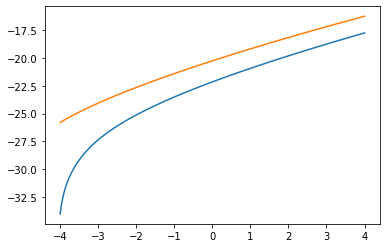

In [10]:
plt.plot(model.bgrid, v.T);

The value function converges quickly, and we can plot the conditional value function based on labor income draw above. 

We have assumed that parallel computation is more efficient, but this is not always the case, as parallel computing usually requires some overhead computation time and memory, as well as good programming decisions. To check if indeed parallel computation is desirable, we can create a $T$ operator that does not use parallelization, and compare computation time.

In [11]:
T_np = T_operator(model, use_parallel=False)

In [12]:
%%timeit
solve_value(model, T, 1.0, skip_policy=True, verbose=False)

138 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
solve_value(model, T_np, 1.0, skip_policy=True, verbose=False)

104 ms ± 750 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


As we see above, parallel computation is on average a few microseconds faster, and I believe in more complex models the advantages are more significant. This result varies depending on your hardware and other processes going on in your system.

We have now developed a sub-routine that is able to quickly solve the value and policy functions, given a price of bonds. 

# The stationary distribution and the $G$ operator

\begin{equation}
    (G\mu)(B) = \int_S P(s,B)d\mu \text{ for } B \in \beta_S
\end{equation}

In [14]:
def G_operator(model, parallel_flag=True):

    π = model.π
    Nz, Nμ = model.Nz, model.Nμ
    bgrid, μgrid = model.bgrid, model.μgrid

    μ, g = model.μ, model.g
    ind, w = model.ind, model.w

    @njit
    def interpgrid(g):

        grid = np.empty((Nz, Nμ))

        for zi in range(Nz):
            grid[zi] = interp(bgrid, g[zi], μgrid)

        return grid

    @njit
    def weight(x, ind):

        next = np.take(μgrid, ind)
        prev = np.take(μgrid, ind - 1)

        return (x - prev) / (next - prev)

    @njit
    def get_weights(g):

        gμ = interpgrid(g)
        ind = np.searchsorted(μgrid, gμ)
        ind = np.where(ind == 0, 1, ind)
        ind = np.where(ind == Nμ, Nμ - 1, ind)
        w = weight(gμ, ind)

        return ind, w

    @njit
    def G(μ, ind, w, g=g):

        μ_new = np.zeros_like(μ)

        if np.isnan(w[0, 0]):
            ind, w = get_weights(g)

        for zi in range(Nz):
            for bi in range(Nμ):
                if μ[zi, bi] > 0.0:

                    bj = ind[zi, bi]
                    wb = w[zi, bi]

                    for zj in range(Nz):
                        μ_new[zj, bj] += wb * π[zi, zj] * μ[zi, bi]
                        μ_new[zj, bj - 1] += (1 - wb) * π[zi, zj] * μ[zi, bi]

        return μ_new, ind, w

    G(μ, ind, w, g)

    return G

- $\texttt{use\_existing}$:
- $\texttt{tol}$:
- $\texttt{max\_iter}$:
- $\texttt{verbose}$:
- $\texttt{print\_skip}$:

In [15]:
def solve_distribution(
    model, G, use_existing=False, tol=1e-5, max_iter=2000, verbose=True, print_skip=25
):

    start = time()

    if not use_existing:
        model.init_distribution()

    μ, g = model.μ, model.g
    ind, w = model.ind, model.w

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        μ_new, ind, w = G(μ, ind, w, g)
        error = np.max(np.abs(μ_new - μ))
        μ = μ_new / np.sum(μ_new)
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Distribution error at iteration {i} is {error:.4e}.")

    end = time()

    runtime = end - start

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"Distribution error at iteration {i} is {error:.4e}.\n")
        print(f"Distribution converged in {i} iterations and {runtime:.4f} seconds.\n")

    model.set_distribution(μ, ind, w)
    return μ

In [16]:
G = G_operator(model)

In [17]:
μ = solve_distribution(model, G)

Distribution error at iteration 25 is 2.0038e-02.
Distribution error at iteration 50 is 1.3703e-03.
Distribution error at iteration 75 is 1.0302e-04.
Distribution error at iteration 91 is 9.8976e-06.

Distribution converged in 91 iterations and 0.0091 seconds.



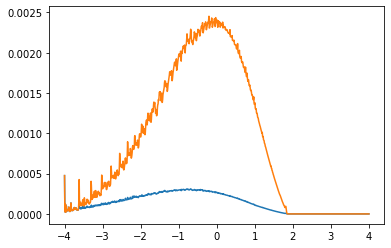

In [18]:
plt.plot(model.μgrid, μ.T);

In [19]:
def A_operator(model):

    μ, μgrid = model.μ, model.μgrid

    @njit
    def A(μ):
        return np.sum(μ @ μgrid)

    A(μ)

    return A

# Solving the model

In [20]:
def solve_model(
    model,
    T,
    G,
    A,
    q_bounds=None,
    tol=1e-4,
    max_iter=2000,
    reset=True,
    use_existing=False,
    skip_policy=False,
    solve_skip=100,
    verbose="all",
    print_skip=100,
):

    start = time()

    if q_bounds is None:
        q_bounds = [model.β, 1 / model.β]

    verb = verbose == "all"

    qlow, qhigh = q_bounds

    if reset:
        model.init_value()
        model.init_distribution()

    def objective(q):

        if verbose == "all" or verbose == "summary":
            print(f"Evaluating solution at q = {q:.6f}.\n")

        v, g = solve_value(
            model,
            T,
            q,
            tol=tol,
            max_iter=max_iter,
            use_existing=use_existing,
            skip_policy=skip_policy,
            solve_skip=solve_skip,
            verbose=verb,
            print_skip=print_skip,
        )

        μ = solve_distribution(
            model,
            G,
            tol=tol * 0.1,
            max_iter=max_iter,
            use_existing=False,
            verbose=verb,
            print_skip=int(print_skip / 4),
        )
        B = A(μ)

        if verbose == "all" or verbose == "summary":
            print(f"The aggregate balance for q = {q:.6f} is B = {B:.6f}.\n")
            print("-------------------------------------------------------\n")

        return B

    qstar, result = root(objective, qlow, qhigh, xtol=tol * 0.1, full_output=True)

    Bstar = objective(qstar)

    iters = result.function_calls + 1

    end = time()

    runtime = end - start

    print(f"Model converged in {iters} iterations and {runtime:.4f} seconds.")

    model.set_solution(qstar, Bstar)

    return qstar, Bstar

In [21]:
A = A_operator(model)

In [22]:
solve_model(model, T, G, A, verbose="summary")

Evaluating solution at q = 0.993220.

The aggregate balance for q = 0.993220 is B = 2.052284.

-------------------------------------------------------

Evaluating solution at q = 1.006826.

The aggregate balance for q = 1.006826 is B = -1.600514.

-------------------------------------------------------

Evaluating solution at q = 1.000865.

The aggregate balance for q = 1.000865 is B = -0.765006.

-------------------------------------------------------

Evaluating solution at q = 0.998150.

The aggregate balance for q = 0.998150 is B = -0.062666.

-------------------------------------------------------

Evaluating solution at q = 0.997858.

The aggregate balance for q = 0.997858 is B = 0.040579.

-------------------------------------------------------

Evaluating solution at q = 0.997970.

The aggregate balance for q = 0.997970 is B = 0.000295.

-------------------------------------------------------

Evaluating solution at q = 0.997972.

The aggregate balance for q = 0.997972 is B = -

(0.997971053979755, 1.3600828877025073e-07)

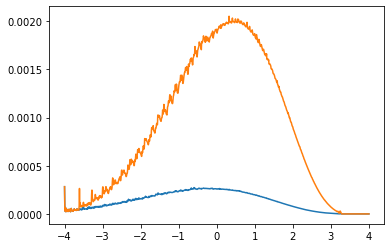

In [23]:
plt.plot(model.μgrid, model.μ.T);

In [24]:
solve_model(model, T, G, A, skip_policy=True, verbose=False)

Model converged in 8 iterations and 1.1519 seconds.


(0.99797105445102, -3.121781626258535e-08)

In [25]:
solve_model(model, T, G, A, skip_policy=True, verbose=False, use_existing=True)

Model converged in 10 iterations and 0.6101 seconds.


(0.997971371090888, -0.001244835981068601)

# References

Huggett, M. (1993). The risk-free rate in heterogeneous-agent incomplete-insurance economies. Journal of Economic Dynamics and Control, 17(5-6):953-969